## 第4週、4日目へようこそ - 大きなプロジェクトの準備！

# Sidekick

紹介する時が来ました：

1. 構造化出力
2. マルチエージェントフロー

### 概要
LangGraphとLangChainを用いた「Sidekick」というAIアシスタントのプロジェクト準備がテーマ

- **構造化出力（Structured Outputs）** と **マルチエージェントフロー（Multi-agent flow）** を導入
- 「Sidekick」という「成功基準を満たすまで自律的に対話・作業を繰り返すAIアシスタント」を構築・体験する。

- 1. 準備  
インポート、環境変数の読込

- 2. 構造化出力の定義  
PydanticのBaseModelを使い、構造化出力の `EvaluatorOutput` クラスを定義。

- 3. Stateの定義  
TypedDictで状態（会話履歴、成功基準、フィードバックなど）を定義。

- 4. ツール、LLMの準備   
エージェント・ノードの使うツール、LLMを準備。

- 5. ２つのエージェント・ノードの定義
  - 作業者ノード: ユーザーの依頼・成功基準をもとにタスクを遂行、必要ならツールを使う。
  - 評価者ノード: 作業者の応答を評価し、成功か・ユーザー入力が必要か判定、フィードバックを返す。

- 6. グラフ構築
  - StateGraph（Node、Edge）を構築
  - Mermaid記法でグラフ可視化も可能。

- 7. GradioによるUI作成
SidekickマルチエージェントフローとのチャットUIを作成

In [1]:
# import

# 基本
import uuid
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from typing import Annotated, TypedDict, List, Dict, Any, Optional

# langchain
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_community.agent_toolkits import PlayWrightBrowserToolkit
from langchain_community.tools.playwright.utils import create_async_playwright_browser

# langgraph
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver

# 表示
from IPython.display import Image, display
import gradio as gr

In [2]:
load_dotenv(override=True)

True

### BaseModelを使用して構造化出力のスキーマを定義

In [3]:
# 最初に構造化された出力を定義します

class EvaluatorOutput(BaseModel):
    feedback: str = Field(description="補助作業者の応答に関するフィードバック") #"Feedback on the assistant's response")
    success_criteria_met: bool = Field(description="成功基準が満たされているかどうか") #"Whether the success criteria have been met")
    user_input_needed: bool = Field(description="ユーザーからの入力や説明がさらに必要な場合、または補助作業者が停止している場合は True になります") #"True if more input is needed from the user, or clarifications, or the assistant is stuck")

### TypedDictを再度使用してStateを定義

しかし、これで実際に管理すべき情報が増えました！

メッセージはReducerを使用します。

その他の値は、状態の変化に応じて上書きされる単なる値です。

In [4]:
# State

class State(TypedDict):
    
    # 通常、存在するメッセージ
    messages: Annotated[List[Any], add_messages]
    
    # 成功基準に付いて説明する文字列
    success_criteria: str
    
    # 以下は構造化出力にもあるフィールド
    feedback_on_work: Optional[str]
    success_criteria_met: bool
    user_input_needed: bool

### Async Playwrightツール（3_lab3と同様）

In [5]:
import nest_asyncio
nest_asyncio.apply()
async_browser =  create_async_playwright_browser(headless=False)  # ヘッド「フル」モード
toolkit = PlayWrightBrowserToolkit.from_browser(async_browser=async_browser)
tools = toolkit.get_tools()

### ２つのエージェント・ノード用のLLMを初期化

In [6]:
# 作業者ノード用
worker_llm = ChatOpenAI(model="gpt-4o-mini")
worker_llm_with_tools = worker_llm.bind_tools(tools)

# 評価者ノード用
evaluator_llm = ChatOpenAI(model="gpt-4o-mini")
evaluator_llm_with_output = evaluator_llm.with_structured_output(EvaluatorOutput)

### エージェント・ノードの定義
- ユーザ → 補助作業者 ⇔ 評価者 → ユーザ のループ。
- 評価者 → 補助作業者 となるときは、`feedback_on_work` に文字列が入力される。

#### 作業者ノード

In [7]:
def worker(state: State) -> Dict[str, Any]:
    system_message=f"""
        あなたは、ツールを使ってタスクを完了できる、頼りになる「補助作業者」です。
        ユーザーに質問や説明をするか、成功基準が満たされるまで、タスクに取り組み続けます。
        成功基準は次のとおりです。: {state['success_criteria']}
        この課題についてユーザーへの質問、または最終的な回答のいずれかで返信してください。
        ユーザーへの質問がある場合は、質問内容を明確に述べて返信する必要があります。
        例：「質問：概要と詳細な回答のどちらを希望するかを明確にしてください。」
        回答が終わったら、最終的な回答を返信してください。質問はせず、回答のみを返信してください。
        """
    
    x = f"""
        You are a helpful assistant that can use tools to complete tasks.
        You keep working on a task until either you have a question or clarification for the user, or the success criteria is met.
        This is the success criteria: {state['success_criteria']}
        You should reply either with a question for the user about this assignment, or with your final response.
        If you have a question for the user, you need to reply by clearly stating your question. An example might be:
        Question: please clarify whether you want a summary or a detailed answer
        If you've finished, reply with the final answer, and don't ask a question; simply reply with the answer.
        """
    
    if state.get("feedback_on_work"): # 評価者からのフィードバッグの場合、システム・メッセージを追加
        system_message  += f"""
            以前、課題を完了したと思っていたのですが、成功基準を満たしていなかったため、回答が却下されました。
            却下された理由に関するフィードバックは次のとおりです。: {state['feedback_on_work']}
            このフィードバックを参考に、成功基準を満たしているか、ユーザーに質問があるかを確認しながら、課題を続行してください。
        """
        x += f"""
            Previously you thought you completed the assignment, but your reply was rejected because the success criteria was not met.
            Here is the feedback on why this was rejected: {state['feedback_on_work']}
            With this feedback, please continue the assignment, ensuring that you meet the success criteria or have a question for the user.
        """
    
    # 会話履歴中のSystemMessageをチェックし
    # ・あれば内容を更新し
    # ・なければ新たに先頭に追加

    found_system_message = False
    messages = state["messages"]

    # 会話履歴の中に
    for message in messages:
        # SystemMessageが既にあれば
        if isinstance(message, SystemMessage):
            # 内容を更新し、
            message.content = system_message
            found_system_message = True

    # なければ新たに先頭に追加
    if not found_system_message:
        messages = [SystemMessage(content=system_message)] + messages
    
    # プロンプトをLLM（ツール付き）で処理
    response = worker_llm_with_tools.invoke(messages)
    
    # 更新された状態を返す
    return {
        "messages": [response],
    }

In [8]:
# 作業者ノードが次にどのノードへ処理を渡すかを判断するための関数
def worker_router(state: State) -> str:

    # 直近のメッセージ（last_message）を調べ、
    last_message = state["messages"][-1]

    # tool_callsプロパティが在って値が入っているか・いないか
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools" # ツール・ノードに進む
    else:
        return "evaluator" # 評価者ノードに進む

In [9]:
# 会話履歴（評価ロジックなど利用）を整形する関数
def format_conversation(messages: List[Any]) -> str:
    # HumanMessage、AIMessageは、StateSnapshotで確認したState情報
    conversation = "Conversation history:\n\n"
    for message in messages:
        if isinstance(message, HumanMessage):
            conversation += f"User: {message.content}\n"
        elif isinstance(message, AIMessage):
            text = message.content or "[Tools use]"
            conversation += f"Assistant: {text}\n"
    return conversation

#### 評価者ノード

In [10]:
def evaluator(state: State) -> State:
    last_response = state["messages"][-1].content

    system_message = """
        あなたは、補助作業者がタスクを正常に完了したかどうかを判断する評価者です。指定された基準に基づいて、補助作業者の最後の応答を評価します。
        「フィードバックと成功基準が満たされたかどうか」そして「ユーザーからの追加入力が必要かどうかの判断」を返信してください。
        """
    y = """
        You are an evaluator that determines if a task has been completed successfully by an Assistant.
        Assess the Assistant's last response based on the given criteria. Respond with your feedback, and with your decision on whether the success criteria has been met,
        and whether more input is needed from the user.
        """
    
    user_message =f"""
        ユーザーと補助作業者間の会話を評価します。補助作業者からの最後の応答に基づいて、実行するアクションを決定します。
        補助作業者間との会話全体（ユーザーの元のリクエストとすべての返信を含む）は、{format_conversation(state['messages'])} です。
        この課題の成功基準は次のとおりです: {state['success_criteria']}
        評価している補助作業者からの最終応答は次のとおりです: {last_response}
        フィードバックを送信し、この応答が成功基準を満たしているかどうかを判断します。
        また、説明不足による行き詰まりなど、補助作業者に追加のユーザー指示が必要かどうかを判断します。
        """
    
    y = f"""
    You are evaluating a conversation between the User and Assistant. You decide what action to take based on the last response from the Assistant.
    The entire conversation with the assistant, with the user's original request and all replies, is:{format_conversation(state['messages'])}
    The success criteria for this assignment is: {state['success_criteria']}
    And the final response from the Assistant that you are evaluating is: {last_response}
    Respond with your feedback, and decide if the success criteria is met by this response.
    Also, decide if more user input is required, either because the assistant has a question, needs clarification, or seems to be stuck and unable to answer without help.
    """
    
    if state["feedback_on_work"]: # 評価者からのフィードバッグの履歴
        #f"Also, note that in a prior attempt from the Assistant, you provided this feedback: {state['feedback_on_work']}\n"
        user_message += f"また、補助作業者が以前に試みた際に、次のフィードバックを提供していたことにもご注意ください: {state['feedback_on_work']}"
        #"If you're seeing the Assistant repeating the same mistakes, then consider responding that user input is required."
        user_message += "補助作業者が同じ間違いを繰り返している場合は、ユーザーによる入力が必要であることを伝えてください。"

    # ※ ココのHumanMessageは、ユーザと補助作業の会話履歴で主に、補助作業の最後のレスポンスにフォーカスしている。
    evaluator_messages = [SystemMessage(content=system_message), HumanMessage(content=user_message)]
    # プロンプトをLLMで処理、結果は構造化出力で返される。
    eval_result = evaluator_llm_with_output.invoke(evaluator_messages)

    # 更新された状態を返す
    new_state = {
        "messages": [{"role": "assistant", "content": f"この回答に対する評価者からのフィードバック: {eval_result.feedback}"}],
        "feedback_on_work": eval_result.feedback,
        "success_criteria_met": eval_result.success_criteria_met,
        "user_input_needed": eval_result.user_input_needed
    }
    return new_state

In [11]:
# 評価者ノードが次にどのノードへ処理を渡すかを判断するための関数
def route_based_on_evaluation(state: State) -> str:
    if state["success_criteria_met"] or state["user_input_needed"]:
        return "END"
    else:
        return "worker"

In [12]:
# グラフを作成
# NodeとEdgeを追加してGraphを作成
graph_builder = StateGraph(State)

# ノードを追加します
graph_builder.add_node("worker", worker)
graph_builder.add_node("tools", ToolNode(tools=tools))
graph_builder.add_node("evaluator", evaluator)

# エッジを追加します
graph_builder.add_edge(START, "worker")
graph_builder.add_conditional_edges("worker", worker_router, {"tools": "tools", "evaluator": "evaluator"})
graph_builder.add_edge("tools", "worker")
graph_builder.add_conditional_edges("evaluator", route_based_on_evaluation, {"worker": "worker", "END": END})

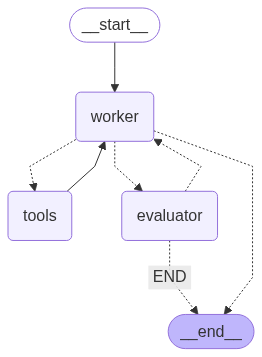

In [13]:
# グラフをコンパイルして可視化
memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

# なにやら、未定義の worker → END が出力されるが...？

### 次は、スーパーステップをキックオフするためのGradioコールバック
イベントハンドラで、4変数（message, success_criteria, history, thread）を処理


In [14]:
# thread(_id) は uuid4
def make_thread_id() -> str:
    return str(uuid.uuid4())

# 変数のリセット
async def reset():
    return "", "", None, make_thread_id()

In [15]:
# スーパーステップ（一連の処理）をキックオフ（実行）して返す
async def process_message(message, success_criteria, history, thread):

    # スーパーステップの...
    # config
    config = {"configurable": {"thread_id": thread}}
    # state
    state = {
        # 継続
        "messages": message,
        "success_criteria": success_criteria,
        # 初期値
        "feedback_on_work": None,
        "success_criteria_met": False,
        "user_input_needed": False
    }

    # Graphを非同期実行
    result = await graph.ainvoke(state, config=config)

    # user, reply, feedbackは更新
    user = {"role": "user", "content": message}
    reply = {"role": "assistant", "content": result["messages"][-2].content}
    feedback = {"role": "assistant", "content": result["messages"][-1].content}
    return history + [user, reply, feedback]

### そして今、私たちのSidekick UIを起動します

In [16]:
with gr.Blocks(theme=gr.themes.Default(primary_hue="emerald")) as demo:
    gr.Markdown("## Sidekick Personal Co-worker")
    
    # スレッド初期化（UI立ち上げ毎に初期化）
    thread = gr.State(make_thread_id())

    # 各種UI要素
    with gr.Row():
        # Chat UI
        chatbot = gr.Chatbot(label="Sidekick", height=300, type="messages")
    with gr.Group():
        with gr.Row():
            message = gr.Textbox(show_label=False, placeholder="あなたのsidekickへのリクエスト")
        with gr.Row():
            success_criteria = gr.Textbox(show_label=False, placeholder="あなたの成功基準は何ですか?")
    with gr.Row():
        # リセット
        reset_button = gr.Button("Reset", variant="stop")
        # 実行
        go_button = gr.Button("Go!", variant="primary")

    # イベント・ハンドラ、process_message関数の引数・戻り値としては、
    # [message, success_criteria, chatbot(=history), thread]が渡され、
    # [chatbot](=history + [user, reply, feedback])が返る。
    message.submit(process_message, [message, success_criteria, chatbot, thread], [chatbot])
    success_criteria.submit(process_message, [message, success_criteria, chatbot, thread], [chatbot])
    reset_button.click(reset, [], [message, success_criteria, chatbot, thread])
    go_button.click(process_message, [message, success_criteria, chatbot, thread], [chatbot])
    
demo.launch()

* Running on local URL:  http://127.0.0.1:7865
* To create a public link, set `share=True` in `launch()`.


### 入力の例
- What is the current USD/GBP exchange rate / An accurate answer
- 現在のUSD/GBP為替レートはいくらですか？ / 正確な回答

### 最後に、ログなど確認

https://smith.langchain.com

<table style="margin: 0; text-align: left; width:100%">
    <tr>
        <td style="width: 150px; height: 150px; vertical-align: middle;">
            <img src="../assets/thanks.png" width="150" height="150" style="display: block;" />
        </td>
        <td>
            <h2 style="color:#00cc00;">Sidekick の初版作成おめでとうございます！</h2>
            <span style="color:#00cc00;">これはコースの中でも非常に重要な瞬間です。非常にパワフルな何かの始まりを告げたのです。そして、LangGraph の素晴らしいエージェントフレームワークを習得しました。もしかしたら、私と同じように、LangGraph に懐疑的だったあなたも、LangGraph のファンに転向しているかもしれませんね。<br/><br/>もう一度言わないと編集者に殺されてしまうでしょうが、Udemy でコースを評価していただけると大変ありがたいです。Udemy がこのコースを他の人に公開するかどうかを決める主な基準であり、評価は大きな違いを生みます。<br/><br/>もう一つお知らせですが、まだ <a href="https://www.linkedin.com/in/eddonner/">LinkedIn でつながって</a>いない方は、ぜひフォローしてください！コースの進捗状況を投稿したい場合は、私にタグを付けてください。露出を高めるために私が協力します。
            </span>
        </td>
    </tr>
</table>